# Movie Recommendations
#### 02807 Computational tools for data science 2024

This project aims to create a Movie Recommendations System, based on IMDB scrapped data.
This goal will be achieved through 2 different methods:

The first method uses Jaccard similarity and ..... to compare Movie titles and descriptions.

The second method uses clustering via ... , to create clusters of similar movies.

On top of this, a machine learning model is trained on sentiment-labelled IMDB reviews, so that scrapped user reviews can be used to determine the general sentiment of a recommended movie.






# Table of Contents

Bliver genereret til sidst

## Libraries

In [13]:
import csv
#import mmh3
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import nltk
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bs4 import BeautifulSoup
import pickle 


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Loading Data

In [ ]:
# Load descriptions from data/movies_metrics.csv, scrapped from IMDB using a script
Movies = pd.read_csv('movie_titles_and_ids.csv')
Movies.head(2)



,Name,ID,Year,Length,Age,Rating,Description
0,The Shawshank Redemption,tt0111161,1994,2h 22m,15,9.3 (3M),A banker convicted of uxoricide forms a friend...
1,The Godfather,tt0068646,1972,2h 55m,15,9.2 (2.1M),The aging patriarch of an organized crime dyna...


In [8]:
titles = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
print("There are", len(titles), "movies in the dataset")

There are 3122 movies in the dataset


In [ ]:
# Loading training data from kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
kaggle_sentiments = pd.read_csv("training_data.csv") 
print(kaggle_sentiments.head(4))
print("There are", len(kaggle_sentiments), "reviews in the Kaggle dataset")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
There are 50000 reviews in the dataset


In [21]:
# Load the reviews from the scrapped data
with open('reviews.pkl', 'rb') as file:
    scrapped_reviews = pd.read_pickle(file)

scrapped_reviews = pd.DataFrame.from_dict(scrapped_reviews)

print("There are", len(scrapped_reviews), "reviews, per movie, in the scrapped review dataset")



There are 25 reviews, per movie, in the scrapped review dataset


# Preprocessing 
To preprocess the data, some methods are defined here.
The following is performed:

- Removal of:
    - HTML tags
    - URL's
    - non-alphabetic characters
    - Stop words (The, a, on, etc.)
- Modification:
    - Conversion to lowercase
    - Tokenization (splitting into words)
    - Lemmetization (Removal of word endings to get base word)

These are done to standardize the texts, and to remove anything but the most essential. TF-IDF is also used throughout the project to extract the most important information from the texts. 

In [22]:
def simple_preprocess_text(corpus):
    # Remove HTML tags
    corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]
    # Remove urls
    corpus = [re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) for text in corpus]
    # Remove non-alphabetic characters
    corpus = [re.sub("[^a-zA-Z]", " ", text) for text in corpus]
    # Convert to lowercase
    corpus = [text.lower() for text in corpus]
    return corpus

def preprocessing_lemmatization(corpus):
    # Tokenize the text (split it into words)
    corpus = [word_tokenize(text) for text in corpus]
    # Remove stop words (The, a, on, etc)
    stop_words = set(stopwords.words("english"))
    corpus = [[word for word in text if word not in stop_words] for text in corpus]
    # Lemmatization,
    # AKA remove word endings to get the base form
    lemmatizer = nltk.stem.WordNetLemmatizer()
    corpus = [[lemmatizer.lemmatize(word) for word in text] for text in corpus]
    # Join the words back into one string
    corpus = [" ".join(text) for text in corpus]
    return corpus


In [23]:
# EXAMPLE of pre-processing some text
sample_text = ["<p>It's a great movie. I love it! <a href='http://www.google.com'>Google</a></p>"]
print(sample_text)

test= simple_preprocess_text(sample_text)
print(test)
test= preprocessing_lemmatization(test)

print(test)

["<p>It's a great movie. I love it! <a href='http://www.google.com'>Google</a></p>"]
['it s a great movie  i love it  google']
['great movie love google']


# Similarity of descriptions (reviews); Method 1
## Following W4
* Shingles - k-shingle is any substring of length k found within the document.
* Minhashing - Hashing each shingle to a number and keeping the minimum of the hash values.
* Signatures - Minhashing for multiple hash functions and keeping the minhash values for each hash function in a list.
* Jaccard similarity - The fraction of the number of elements in the intersection of two sets and the number of elements in the union of the two sets. Approximated by counting number of minhash values in the signature lists that match and dividing by the number of hash functions.
* Locality-Sensitive Hashing (LSH) - Dividing the signature matrix into bands and hashing the bands. If two signatures are similar, they will hash to the same bucket with high probability.



### Jaccard similarity

In [25]:
def jaccard(S, T):
    intersection = len(S & T)
    union = len(S | T)
    return intersection / union

movie_1 = random.choice(titles)
movie_2 = random.choice(titles)
print(movie_1, '-', movie_2)

# Split words into sets
movie_1 = set(movie_1.split())
movie_2 = set(movie_2.split())

print(movie_1, '-', movie_2)
print(jaccard(movie_1, movie_2))


Mustang (2015) - White Men Can't Jump (1992)
{'Mustang', '(2015)'} - {'Jump', '(1992)', "Can't", 'White', 'Men'}
0.0


In [27]:
#similar

In [28]:
def find_matches(titles, threshold):
    # Now compare all pairs of candidates
    similar = []
    for i, A in tqdm(enumerate(titles)):
        for j in range(i+1, len(titles)):
            B = titles[j]

            sim = jaccard(set(A.split()), set(B.split()))
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = find_matches(titles, 0.67)

# 10 secs

3122it [00:09, 314.01it/s]


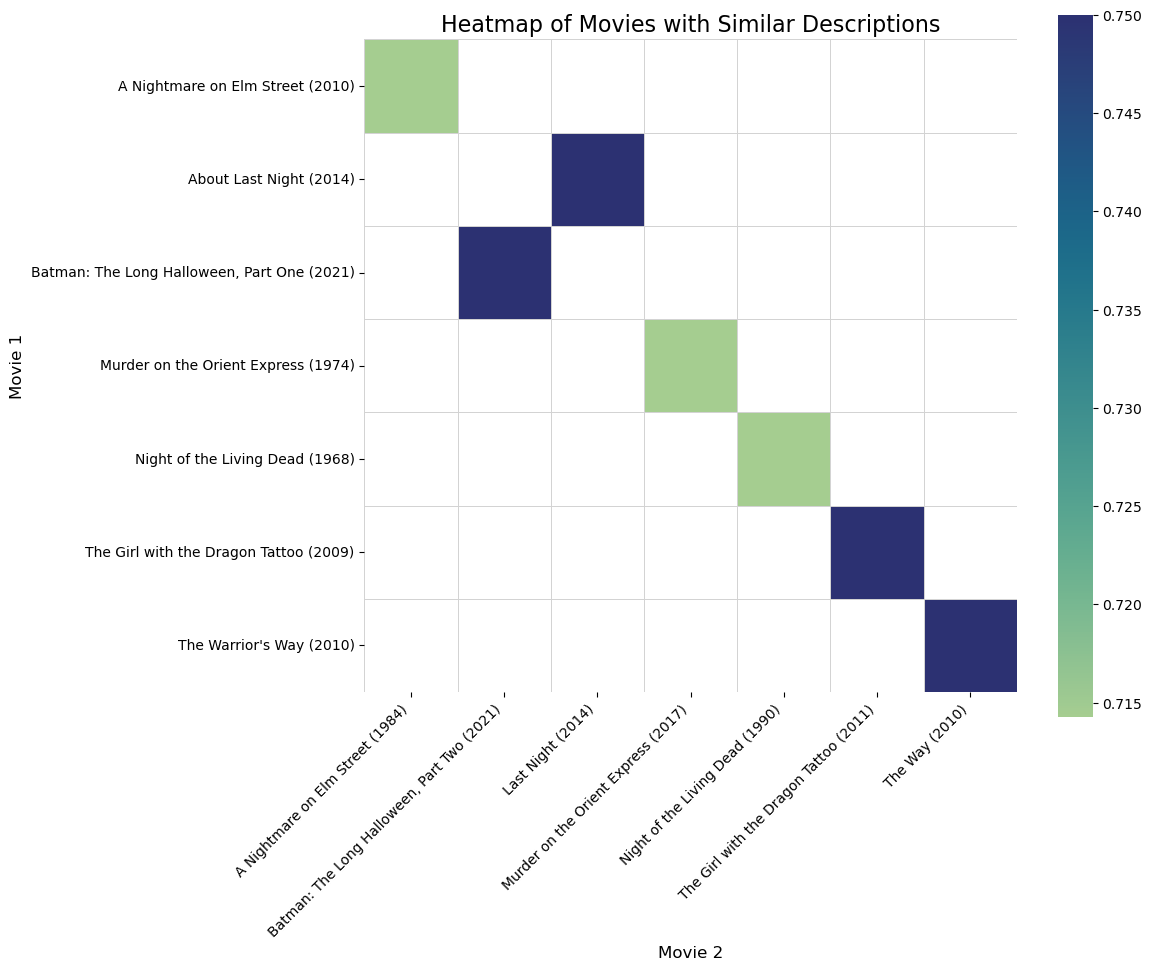

In [29]:
def plot_HeatMap(similar):
    # Extract keys (pairs of movies) and values (similarity scores) from the list of tuples
    key1 = [pair[0] for pair in similar]  # First movie in each tuple
    key2 = [pair[1] for pair in similar]  # Second movie in each tuple
    values = [pair[2] for pair in similar]  # Similarity scores

    # Create a dataframe from the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})

    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')

    # Set up the plot
    plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
    sns.heatmap(
        df_pivot,
        cmap='crest',
        annot=False,  # No annotations
        cbar=True,
        mask=df_pivot.isna(),
        linewidths=0.5,  # Add grid lines between cells
        linecolor='lightgray',  # Grid line color
        square=True  # Ensure square cells
    )

    # Customize labels and title
    plt.title('Heatmap of Movies with Similar Descriptions', fontsize=16)
    plt.xlabel('Movie 2', fontsize=12)
    plt.ylabel('Movie 1', fontsize=12)

    # Rotate tick labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_HeatMap(_similar)

### Shingle

In [31]:
def shingle(s, q):
    return {s[i:i+q] for i in range(len(s) - q + 1)}

### Minhashing and Signature

In [32]:
import hashlib
def listhash(shingle, seed):
	return int(hashlib.sha256((shingle + str(seed)).encode('utf-8')).hexdigest(), 16) % 2**32-1

def minhash(shingles, seed):
    return min(listhash(s, seed) for s in shingles)

def signature(shingles, k):
	return [minhash(shingles, seed) for seed in range(k)]

### Signature for entire dataset

In [34]:
descriptions = Movies['Description']
q = 5 # length of shingle  (5 ok for emails)
k = 100 # number of minhashes
keys = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
# docs = Movies.set_index('Name')['Description'].to_dict() # dictionary mapping document id to document contents
docs = {key : desc for key, desc in zip(keys, descriptions)}

Observing that there will be an intersection of shingles in documents, this can be used to define the signatures for the entire dataset. Instead of iterating over documents and defining signatures individually, iterate over shingles

In [35]:
def MakeSignatures(docs, shingles, U):
    SIG = {doc : [float('inf') for _ in range(k)] for doc in docs}

    for s in tqdm(U):
        # hashes = signature(s, k)
        hashes = [listhash(s, seed) for seed in range(k)]
        for doc in docs:
            if s in shingles[doc]:
                for i in range(k):
                    SIG[doc][i] = min(hashes[i], SIG[doc][i])
    return SIG

shingles = {doc: shingle(docs[doc], q) for doc in docs}
U = set([s for doc in shingles for s in shingles[doc]])  # All shingles

signatures = MakeSignatures(docs, shingles, U)

100%|██████████| 87983/87983 [01:22<00:00, 1068.13it/s]


### Approximate Jaccard similarity

In [36]:
# Approximate Jaccard similarity using minhash signatures
def approximate_jaccard(A, B, signatures):
    return sum(i == j for i, j in zip(signatures[A], signatures[B])) / k

In [37]:
# Test
A, B = random.sample(keys, 2)
print(A, '-', B)

doc1 = docs[A]
doc2 = docs[B]
shingle1 = shingle(doc1, q)
shingle2 = shingle(doc2, q)
signature1 = signature(shingle1, k)
signature2 = signature(shingle2, k)

# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
print(approximate_jaccard(A, B, signatures))

Talladega Nights: The Ballad of Ricky Bobby (2006) - The Pledge (2001)
0.006779661016949152
0.03


In [38]:
# Find most similar by description
mx = 0.0
most_similar = None
for i, A in enumerate(keys):
    for j in range(i+1, len(keys)):
        B = keys[j]
        # shingle1 = shingle(docs[A], q)
        # shingle2 = shingle(docs[B], q)
        # sim = jaccard(shingle1, shingle2)
        sim = approximate_jaccard(A, B, signatures)
        if sim > mx:
            mx = sim
            most_similar = (A, B)
print(mx, most_similar)
# Jaccard 

0.28 ('Solaris (2002)', 'Solaris (1972)')


In [39]:
A, B = random.sample(keys, 2)
print(A, '-', B)
# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
matches = sum(1 for i, j in zip(signature1, signature2) if i == j)
print(matches)
print(matches / k)
# jaccard(docs[A], docs[B]), approximate_jaccard(A, B, signatures)

Scott Pilgrim vs. the World (2010) - Breakthrough (2019)
0.006779661016949152
3
0.03


### Locality-Sensitive Hashing
Pick $b$ and $r$ such that $k = br$ and $(1/b)^{1/r} \approx s$, where $s$ is the similarity threshold.

In [40]:
# (1/b)**(1/r)

In [41]:
def fill_buckets(signatures, b, r):
    buckets = {i: {} for i in range(b)}
    for doc in signatures:
        for i in range(b):
            h = hash(tuple(signatures[doc][i*r:(i+1)*r]))
            if h not in buckets[i]:
                buckets[i][h] = []
            buckets[i][h].append(doc)
    return buckets

def lsh(signatures, threshold):
    b = 50
    r = k // b
    buckets = fill_buckets(signatures, b, r)

    candidates = set()
    for bucket in buckets:
        for h in buckets[bucket]:
            if len(buckets[bucket][h]) > 1:
                for doc in buckets[bucket][h]:
                    candidates.add(doc)
    candidates = list(candidates)
    
    # Now compare all pairs of candidates
    similar = []
    for i, A in enumerate(candidates):
        for j in range(i+1, len(candidates)):
            B = candidates[j]
            sim = approximate_jaccard(A, B, signatures)
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = lsh(signatures, 0.22)

### HeatMap

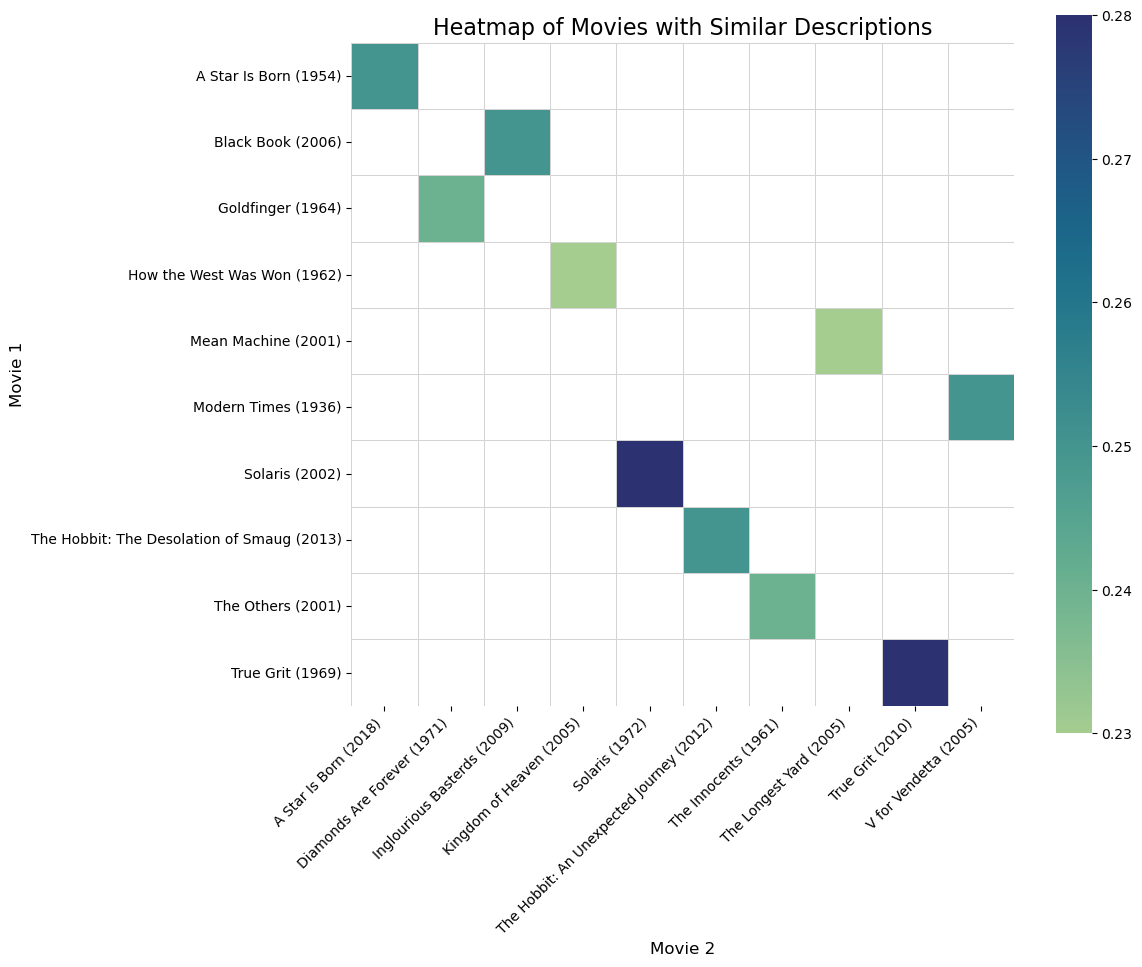

In [42]:
plot_HeatMap(_similar)

# Clustering; Method 2

INDSÆT CLUSTERING UNDER DETTE!!

# Sentiment Analysis

As part of the movie recommendation idea, we want the end user to have an additional data point for their consideration of our recommendation. 

We have therefore decided to employ a sentiment analysis, based on movie reviews. The sentiment analysis will be based on machine learning, employing different models, trained on a [sentiment-labelled IMDB movie review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). As part of this, the movie reviews will be preprocessed, and vectorized, using TF-IDF. 
 

In [43]:
reviews = []
reviews =[review for review in kaggle_sentiments['review']]

In [44]:
processed_text= simple_preprocess_text(reviews)
processed_text= preprocessing_lemmatization(processed_text)


C:\Users\nojan\AppData\Local\Temp\ipykernel_31320\623102517.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]


As shown, the text is now cleaned up, and only the most important words for the sentiment analysis is kept

The next step is to use TF-IDF to extract the most important features from the text. TF stands for term frequency, the frequency of a word appearing in a document. IDF stands for Inverse Document Frequency, which is a weighing method that indicate how commonly a word appears across all the documents, which in our case are the reviews. 

In [45]:
# TF-IDF vectorization,
# which is a way to represent text data as a matrix of numbers
vector = TfidfVectorizer(max_features=5000)
X = vector.fit_transform(processed_text).toarray()
# We will include the sentiment column as the target variable
y = kaggle_sentiments['sentiment'].values

In [ ]:
# Split the data into training and testing sets
# 80% of the data will be used for training and 20% for testing
# The random_state parameter is used to ensure that the data is split in the same way every time the code is run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will now be training and testing on different model types, to evaluate which one is best for our purposes

In [ ]:
models = {}

In [ ]:
# Train a logistic regression model
models['Logistic Regression'] = LogisticRegression()
models['Logistic Regression'].fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Train a SVM model
from sklearn.svm import LinearSVC
models['SVM'] = LinearSVC() # faster converge, if linear
models['SVM'].fit(X_train, y_train)

c:\Users\nojan\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [ ]:
# Train a Naive Bayes model
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()
models['Naive Bayes'].fit(X_train, y_train)

GaussianNB()

In [ ]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(n_jobs=-1)
models['Random Forest'].fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [ ]:
best_model = None
best_accuracy = 0
for model in models:
    y_pred = models[model].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model}")
    print(f"Accuracy of sentiment prediction: {accuracy}")
    print()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"The best model is: {best_model}")


Model: Logistic Regression
Accuracy of sentiment prediction: 0.8878

Model: SVM
Accuracy of sentiment prediction: 0.8828

Model: Naive Bayes
Accuracy of sentiment prediction: 0.7965

Model: Random Forest
Accuracy of sentiment prediction: 0.8486

The best model is: Logistic Regression


The results show that the Logistic Regression performs the best on this dataset.
This is the model we will continue with, when we now apply the trained model on our own scrapped movie dataset.
Each movie has 25 reviews attached

In [ ]:
import pickle 
with open('reviews.pkl', 'rb') as file:
    custom_data = pd.read_pickle(file)



In [ ]:
custom_data = pd.DataFrame.from_dict(custom_data)

In [ ]:
sentiments = {}
bad_data = []
for title in custom_data:
    temp = list(custom_data[title])
    if temp[0] is None:
        bad_data.append(title)
        continue
    temp= simple_preprocess_text(temp)
    temp= preprocessing_lemmatization(temp)
    temp = vector.transform(temp).toarray()
    sentiment = models[best_model].predict(temp)
    sentiments[title] = sentiment

In [ ]:
len(bad_data)

315

In [ ]:
sentiment_scores = {}
for title in sentiments:
    temp = sentiments[title]
    temp_score = (np.count_nonzero(temp == "positive"))
    sentiment_scores[title] = temp_score/len(temp)

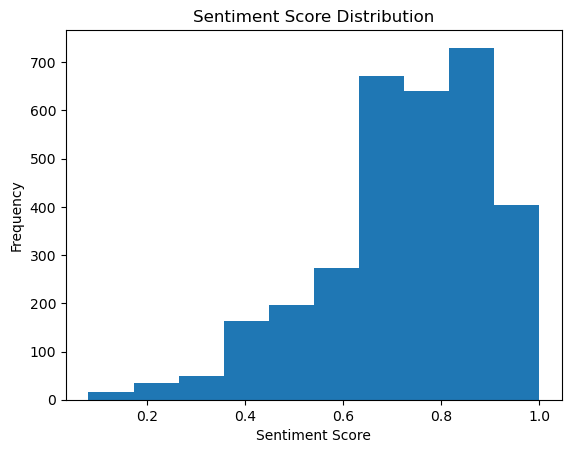

In [ ]:
# histogram of sentiment scores
import matplotlib.pyplot as plt
plt.hist(sentiment_scores.values(), bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()
